# Regression on RBS sequences - Escherichia coli

This notebook shows the regression of RBS sequences.

There are several parts of the implementation. 

- Reading the dataset
- Embedding
    - Label
    - One-hot embedding
    - K-mer 
    - PMW (to be added)
    - Unsupervised (to be added)
- Kernels
    - Spectrum
    - Mixed Spectrum
    - Weighted Degree
    - Weighted Degree with Shifting
- Evaluate
    - R2 score
    - Plot

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np

import pandas
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels_pairwise import spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF
from sklearn.kernel_ridge import KernelRidge

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading the Dataset

In [3]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

Path = '../data/trainset.rbs1.v2.csv'

df = pandas.read_csv(Path, delimiter=',')
df.head()

,Construct,Barcode,rbs1_1_A,rbs1_1_C,rbs1_1_G,rbs1_1_T,rbs1_2_A,rbs1_2_C,rbs1_2_G,rbs1_2_T,...,rbs2_3_A,rbs2_3_C,rbs2_3_G,rbs2_3_T,Group,ODind,ODhar,FC,rbs1,rbs2
0,RBS629,77DD32,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.410,4.523,1.437982,GGG,GGG
1,RBS678,77DD39,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.359,2.678,1.277175,GGG,GGG
2,RBS353,77DD18,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.334,1.745,1.545141,GGC,GGG
3,RBS403,77DD20,0,0,1,0,0,0,1,0,...,1,0,0,0,Top,0.390,2.166,1.670098,GGC,GGA
4,RBS500,77DD24,0,0,1,0,0,0,1,0,...,0,1,0,0,Top,0.375,2.348,1.621230,GGC,GGC


In [4]:
df['RBS'] = df['rbs1'] + df['rbs2']
data = np.asarray(df[['RBS', 'FC']])
data.shape

(60, 2)

## Regression

- Kernel Ridge Regression
- Gaussian Process Regression


In [5]:
cross_val_flag = False
kernels = [spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw]

### Kernel Ridge Regression 

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=DotProduct(sigma_0=1), kernel_params=None)
Train RMSE:  0.28734486076081606
Test RMSE:  0.25814044373108946


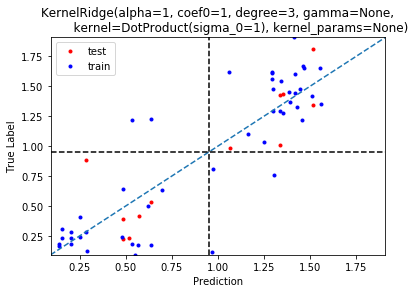

In [6]:
# Baseline: onehot embedding with DotProduct kernel

reg = Regression(KernelRidge(kernel = DotProduct()), data, 'onehot')
reg.train()
reg.evaluate(cross_val_flag = cross_val_flag)

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=DotProduct(sigma_0=1), kernel_params=None)
Train RMSE:  0.2770535241663116
Test RMSE:  0.28775011021106056


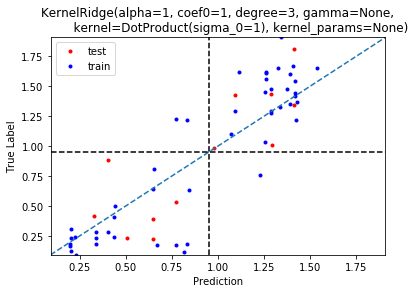

In [7]:
# kmer embedding with DotProduct kernel (l = 3)

reg = Regression(KernelRidge(kernel = DotProduct()), data, 'kmer')
reg.train()
reg.evaluate(cross_val_flag = cross_val_flag)

In [8]:
# Show string kernel performance (l = 3)
# label embedding 

for kernel in kernels:
    reg = Regression(KernelRidge(kernel = kernel), data, embedding_method='label')
    reg.train()
    reg.evaluate(cross_val_flag = cross_val_flag, plot_flag = False)
    print()

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function spectrum_kernel_pw at 0x7f6d575b3378>,
            kernel_params=None)
Train RMSE:  0.2784503338857154
Test RMSE:  0.2868450815325605

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function mixed_spectrum_kernel_pw at 0x7f6d575b3400>,
            kernel_params=None)
Train RMSE:  0.306770209982553
Test RMSE:  0.3727449605515199

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function WD_kernel_pw at 0x7f6d575b3488>,
            kernel_params=None)
Train RMSE:  0.24145728283420298
Test RMSE:  0.2784942500428455

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function WD_shift_kernel_pw at 0x7f6d575b3510>,
            kernel_params=None)
Train RMSE:  0.23989251217060262
Test RMSE:  0.28078538007111864



### Gaussian Process Regression

In [9]:
# # baseline: onehot embedding with DotProduct Kernel 
reg = Regression(GaussianProcessRegressor(kernel = DotProduct()), data, 'onehot')
reg.train()
reg.evaluate(cross_val_flag = cross_val_flag, plot_flag = False)

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)
Train RMSE:  0.2865400883007255
Test RMSE:  0.26045947869773434


In [10]:
# kmer embedding (l = 3)
reg = Regression(GaussianProcessRegressor(kernel = DotProduct()), data, 'kmer')
reg.train()
reg.evaluate(cross_val_flag = cross_val_flag, plot_flag = False)

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)
Train RMSE:  0.25318088284050083
Test RMSE:  0.27693065212288165


In [ ]:
# Show string kernel performance (l = 3)
# label embedding 

for kernel in kernels:
    reg = Regression(GaussianProcessRegressor(kernel = PairwiseKernel(metric = kernel)), data,\
                 embedding_method='label')
    reg.train()
    reg.evaluate(cross_val_flag = cross_val_flag, plot_flag = False)
    print()

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function spectrum_kernel_pw at 0x7f6d575b3378>),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train RMSE:  0.25318065936493944
Test RMSE:  0.27693253920717364

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function mixed_spectrum_kernel_pw at 0x7f6d575b3400>),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train RMSE:  0.2531756121504354
Test RMSE:  0.27693406866752296

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function WD_kernel_pw at 0x7f6d575b3488>),
                         n_restarts_optimizer=0, no